In [1]:
# Restore session with dill ( Only for continuing the session)
# import dill
# dill.load_session('session.db')

In [2]:
import pandas as pd
import numpy as np 
import pickle
import dill
import seaborn as sns

from ucimlrepo import fetch_ucirepo 
from pathlib import Path
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score

In [3]:
data_cache = Path('assets/data_cache')

if data_cache.is_file():
    with open(data_cache, 'rb') as f:
        df, y = pickle.load(f)
else: 
    # fetch dataset 
    cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
      
    # data (as pandas dataframes) 
    df = cdc_diabetes_health_indicators.data.features 
    y = cdc_diabetes_health_indicators.data.targets 
      
    # metadata 
    print(cdc_diabetes_health_indicators.metadata) 
      
    # variable information 
    print(cdc_diabetes_health_indicators.variables)

    # cache it for further use
    with open(data_cache, 'wb') as f: 
        pickle.dump((df,y), f)

In [4]:
df['diabetes_binary'] = y

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [6]:
df

,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdiseaseorattack,physactivity,fruits,veggies,...,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income,diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1,1,1,45,0,0,0,0,1,1,...,0,3,0,5,0,1,5,6,7,0
253676,1,1,1,18,0,0,0,0,0,0,...,0,4,0,0,1,0,11,2,4,1
253677,0,0,1,28,0,0,0,1,1,0,...,0,1,0,0,0,0,2,5,2,0
253678,1,0,1,23,0,0,0,0,1,1,...,0,3,0,0,0,1,7,5,1,0


In [7]:
(list(df.columns.values))

['highbp',
 'highchol',
 'cholcheck',
 'bmi',
 'smoker',
 'stroke',
 'heartdiseaseorattack',
 'physactivity',
 'fruits',
 'veggies',
 'hvyalcoholconsump',
 'anyhealthcare',
 'nodocbccost',
 'genhlth',
 'menthlth',
 'physhlth',
 'diffwalk',
 'sex',
 'age',
 'education',
 'income',
 'diabetes_binary']

In [8]:
binary_cols = ['highbp',
 'highchol',
 'cholcheck',
 'smoker',
 'stroke',
 'heartdiseaseorattack',
 'physactivity',
 'fruits',
 'veggies',
 'hvyalcoholconsump',
 'anyhealthcare',
 'nodocbccost',
 'diffwalk',
 'sex'
]
multicat_cols = ['age','genhlth', 'education', 'income']
cat_cols = binary_cols + multicat_cols
num_cols = ['bmi','menthlth', 'physhlth','diabetes_binary']

In [9]:
len(binary_cols)

14

In [10]:
df

,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdiseaseorattack,physactivity,fruits,veggies,...,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income,diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1,1,1,45,0,0,0,0,1,1,...,0,3,0,5,0,1,5,6,7,0
253676,1,1,1,18,0,0,0,0,0,0,...,0,4,0,0,1,0,11,2,4,1
253677,0,0,1,28,0,0,0,1,1,0,...,0,1,0,0,0,0,2,5,2,0
253678,1,0,1,23,0,0,0,0,1,1,...,0,3,0,0,0,1,7,5,1,0


In [11]:
# map categorical values
binary_values = {
    0 : 'false',
    1 : 'true'
}

for col in binary_cols: 
    df[col] = df[col].map(binary_values)


In [12]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,253670,253671,253672,253673,253674,253675,253676,253677,253678,253679
highbp,true,false,true,true,true,true,true,true,true,false,...,true,true,true,true,false,true,true,false,true,true
highchol,true,false,true,false,true,true,false,true,true,false,...,true,true,false,false,false,true,true,false,false,true
cholcheck,true,false,true,true,true,true,true,true,true,true,...,true,true,true,true,true,true,true,true,true,true
bmi,40,25,28,27,24,25,30,25,30,24,...,25,23,30,42,27,45,18,28,23,25
smoker,true,true,false,false,false,true,true,true,true,false,...,false,false,true,false,false,false,false,false,false,false
stroke,false,false,false,false,false,false,false,false,false,false,...,false,true,false,false,false,false,false,false,false,false
heartdiseaseorattack,false,false,false,false,false,false,false,false,true,false,...,true,true,true,false,false,false,false,false,false,true
physactivity,false,true,false,true,true,true,false,true,false,false,...,false,false,true,true,false,false,false,true,false,true
fruits,false,false,true,true,true,true,false,false,true,false,...,true,false,true,true,false,true,false,true,true,true
veggies,true,false,false,true,true,true,false,true,true,true,...,false,false,true,true,true,true,false,false,true,false


In [13]:
# change categorical values to cateogary for so that we can better binary hot encode it
genhlth_values = {
    1: 'excellent',
    2: 'very_good',
    3: 'good',
    4: 'fair',
    5: 'poor'
}

df.genhlth = df.genhlth.map(genhlth_values)

In [14]:
 education_values = {
     1 : 'never_attended_school',
     2 : 'grade_1_to_8',
     3 : 'grade_9_to_11',
     4 : 'grade_12_to_high_school_graduate',
     5 : 'college_1_to_3_years',
     6 : 'college_4_to_more'
}
df.education = df.education.map(education_values)

In [15]:
 income_values = {
     1 : 'Less than $10,000',
     2 : '$10,000 to less than $15,000',
     3 : '$15,000 to less than $20,000',
     4 : '$20,000 to less than $25,000',
     5 : '$25,000 to less than $35,000',
     6 : '$35,000 to less than $50,000',
     7 : '$50,000 to less than $75,000',
     8 : '$75,000 or more'
}
df.income = df.income.map(income_values)
df.income = df.income.str.lower().str.replace(' ', '_').str.replace(',','')

In [16]:
age_values = {
    1 :	'Age 18 to 24',
    2 :	'Age 25 to 29',
    3 :	'Age 30 to 34',
    4 :	'Age 35 to 39',
    5 :	'Age 40 to 44',
    6 :	'Age 45 to 49',
    7 :	'Age 50 to 54',
    8 :	'Age 55 to 59',
    9 :	'Age 60 to 64',
    10 : 'Age 65 to 69',
    11 : 'Age 70 to 74',
    12 : 'Age 75 to 79',
    13 : 'Age 80 or older',
}
df.age = df.age.map(age_values)
df.age = df.age.str.lower().str.replace(' ', '_')

In [17]:
# Let's split the data from in train test split 
df_train_full, df_val = train_test_split(df, test_size=0.20, random_state=1)
df_train, df_test = train_test_split(df_train_full, test_size=0.25, random_state =1)

len(df_train_full), len(df_train), len(df_test), len(df_val)

(202944, 152208, 50736, 50736)

In [18]:
df_train.diabetes_binary.value_counts()

diabetes_binary
0    131023
1     21185
Name: count, dtype: int64

This is unbalanced dataset, I think using random forest will be good with enesemble learning.
Even better, we can go for Gradient Boosting, sure this will help. 
Not sure though, will refine it more in future for sure 

In [19]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [20]:
y_train = df_train.diabetes_binary.values
y_test = df_test.diabetes_binary.values
y_val = df_val.diabetes_binary.values

In [21]:
del df_train['diabetes_binary']
del df_val['diabetes_binary']
del df_test['diabetes_binary']

In [22]:
df_train_dict = df_train.to_dict(orient='records')
df_val_dict = df_val.to_dict(orient='records')
df_test_dict = df_test.to_dict(orient='records')

#### EDA Feature importance MI and Corr

In [23]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.diabetes_binary.map({0: 'false', 1 : 'true'}))

df_mi = df_train_full[binary_cols + multicat_cols].apply(calculate_mi)
df_mi.sort_values(ascending=False)

genhlth                 0.044296
highbp                  0.035322
highchol                0.020285
age                     0.020104
diffwalk                0.019762
income                  0.013465
heartdiseaseorattack    0.012517
education               0.007721
physactivity            0.006373
stroke                  0.004462
cholcheck               0.003002
hvyalcoholconsump       0.001974
smoker                  0.001769
veggies                 0.001492
fruits                  0.000824
sex                     0.000485
nodocbccost             0.000461
anyhealthcare           0.000117
dtype: float64

In [22]:
df_train_full[num_cols].corrwith(df_train_full.diabetes_binary)

bmi                0.218196
menthlth           0.070515
physhlth           0.173303
diabetes_binary    1.000000
dtype: float64

#### I thnink I should remove few columns from the list itself as they might not contribute enough
['sex', 'nodocbccost', 'anyhealthcare']

In [23]:
unnecessary_cols = ['sex', 'nodocbccost', 'anyhealthcare', 'fruits', 'veggies']

for col in unnecessary_cols: 
    del df_train_full[col]
    del df_train[col]
    del df_test[col]
    del df_val[col]

In [24]:
df_train.T

,0,1,2,3,4,5,6,7,8,9,...,152198,152199,152200,152201,152202,152203,152204,152205,152206,152207
highbp,false,true,false,true,false,true,false,true,true,false,...,false,false,false,true,true,false,false,true,false,true
highchol,false,true,true,true,false,true,true,false,false,false,...,false,true,false,false,false,false,false,true,true,true
cholcheck,true,true,false,true,false,true,true,true,true,true,...,true,true,true,true,true,true,true,true,true,true
bmi,22,31,23,30,30,30,34,38,29,22,...,25,22,23,22,32,24,27,27,35,25
smoker,false,false,true,true,true,true,true,true,false,false,...,false,true,false,true,false,true,false,true,false,true
stroke,false,false,false,false,false,false,false,false,true,false,...,false,true,false,false,false,false,false,false,false,false
heartdiseaseorattack,false,true,false,false,false,false,false,false,false,false,...,false,false,false,false,false,false,false,false,false,false
physactivity,true,true,true,true,false,false,false,true,true,true,...,true,false,true,true,true,true,true,true,true,true
hvyalcoholconsump,false,false,false,false,false,false,false,false,false,false,...,false,false,false,false,false,false,false,false,false,false
genhlth,excellent,good,excellent,good,excellent,very_good,very_good,fair,poor,excellent,...,very_good,fair,good,excellent,very_good,excellent,very_good,good,good,very_good


#### Approach 1 Random Forest ensemble method

In [25]:
dv = DictVectorizer(sparse=False)
dv.fit(df_train_dict)

DictVectorizer(sparse=False)

In [26]:
X_train = dv.transform(df_train_dict)
X_val = dv.transform(df_val_dict)
X_test = dv.transform(df_test_dict)

In [27]:
rf = RandomForestClassifier(n_estimators=10, random_state = 1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [28]:
y_pred = rf.predict_proba(X_val)[:, 1 ]
y_pred

array([0. , 0.2, 0.3, ..., 0.4, 0.1, 0. ])

In [29]:
roc_auc_score(y_val, y_pred).round(3)

0.745

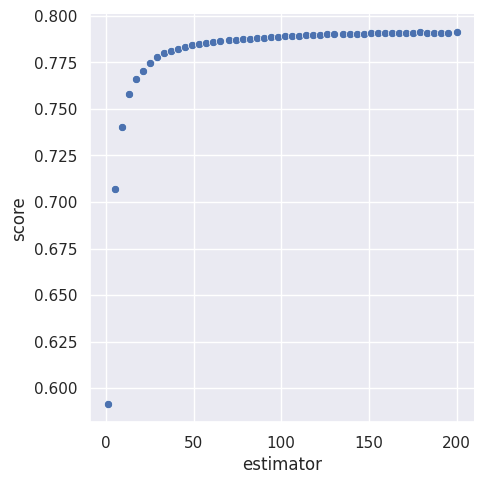

In [70]:
# # Let's try to optimize the hyperparameter for Randomforest Classifier
# # Found best is between 60 to 100 then becomes nearly constant till 200. Trust me or run it to be sure will take around 20 to 30 minutes

# n_estimators = np.linspace(start = 1, stop = 200, num = 50,endpoint = True)
# n_estimators = [int(x) for x in n_estimators]
# scores = []
# for estimator in tqdm(n_estimators, total=50): 
#     rf = RandomForestClassifier(n_estimators = estimator, random_state =1 )
#     rf.fit(X_train, y_train)

#     y_pred = rf.predict_proba(X_val)[:, 1]
#     score = roc_auc_score(y_val, y_pred)
#     scores.append((estimator, score))

# df_scores = pd.DataFrame(scores, columns = ['estimator', 'score'])

# sns.set_theme()
# sns.relplot(data = df_scores, x='estimator', y='score')

In [ ]:
# Also let's find out optimal threshold for this one 

#### Approach 2 Gradient Boosting

In [30]:
## Later On Sometime, let's first work on deployment

### Tuning K-Fold hyperparameter 

In [58]:
## Dump the session (move this down or up whereever you have to dump)
dill.dump_session('session.db')

In [31]:
def train(df_train, y_train, n_estimators=69):
    dict = df_train[cat_cols + num_cols].to_dict(orient='records')

SyntaxError: unexpected EOF while parsing (488273662.py, line 1)